In [1]:
import os
import numpy as np
from PIL import Image

In [2]:
folder_path = r"D:\Fashion\f\images"

# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [3]:
len(image_files)

44441

In [4]:
# Set the target size for resizing the images
target_size = (64, 64)  # Using 64x64 as the target size for consistency

# Initialize an empty list to store processed images
processed_images = []

# Loop through each image file, preprocess, and normalize
for file in image_files:
    # Construct the full image path
    image_path = os.path.join(folder_path, file)
    
    # Open the image
    image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
    # Resize the image to the target size
    image = image.resize(target_size)
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Normalize the image array to the range [0, 1]
    image_array = image_array / 255.0
    
    # Append the processed image to the list
    processed_images.append(image_array)

# Convert the list of processed images to a numpy array
processed_images = np.array(processed_images)

# Print the shape of the processed images array
print("Processed images shape:", processed_images.shape)

Processed images shape: (44441, 64, 64, 3)


In [5]:
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
import cv2
import numpy as np
from collections import defaultdict

def extract_color_histogram(image, bins=(8, 8, 8)):
    """Extract color histogram features from an RGB image."""
    # Ensure image is in uint8 format and has 3 channels
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale and convert to uint8 if needed
    if image.shape[-1] != 3:
        raise ValueError("Expected an RGB image with 3 channels.")

    # Calculate the histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_texture_features(image):
    """Extract texture features using Local Binary Patterns (LBP)."""
    gray_image = rgb2gray(image)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, 2**8 + 1), range=(0, 2**8))
    return hist

def extract_hog_features(image):
    """Extract Histogram of Oriented Gradients (HOG) features."""
    gray_image = rgb2gray(image)
    hog_features, _ = hog(
        gray_image, 
        orientations=8, 
        pixels_per_cell=(16, 16), 
        cells_per_block=(1, 1), 
        visualize=True, 
        channel_axis=None  # Updated argument for skimage
    )
    return hog_features

def extract_pattern_features(image):
    """Extract pattern features using edge detection."""
    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)  # Adjust thresholds as needed
    return edges.flatten()

# Dictionary to hold labeled features
features_dict = defaultdict(list)

# Extract and label features for each image
for img in processed_images:
    # Ensure image is in uint8 format
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    
    # Extract individual feature sets
    color_features = extract_color_histogram(img)
    texture_features = extract_texture_features(img)
    hog_features = extract_hog_features(img)
    pattern_features = extract_pattern_features(img)
    
    # Store features with their respective labels
    features_dict['color'].append(color_features)
    features_dict['texture'].append(texture_features)
    features_dict['hog'].append(hog_features)
    features_dict['pattern'].append(pattern_features)

# Convert the lists to numpy arrays for further analysis
features_dict = {key: np.array(value) for key, value in features_dict.items()}

# Print the shape of each labeled feature set
for label, feature_set in features_dict.items():
    print(f"{label.capitalize()} features shape: {feature_set.shape}")


Color features shape: (44441, 512)
Texture features shape: (44441, 256)
Hog features shape: (44441, 128)
Pattern features shape: (44441, 4096)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Combine all features into a single feature vector per image
combined_features = np.hstack([
    features_dict['color'],
    features_dict['texture'],
    features_dict['hog'],
    features_dict['pattern']
])

# Normalize the combined features
scaler = StandardScaler()
combined_features_normalized = scaler.fit_transform(combined_features)

In [7]:
from sklearn.cluster import KMeans

# Fit K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features_normalized)

# Add cluster labels to your features
combined_features_with_clusters = np.hstack([combined_features_normalized, clusters.reshape(-1, 1)])

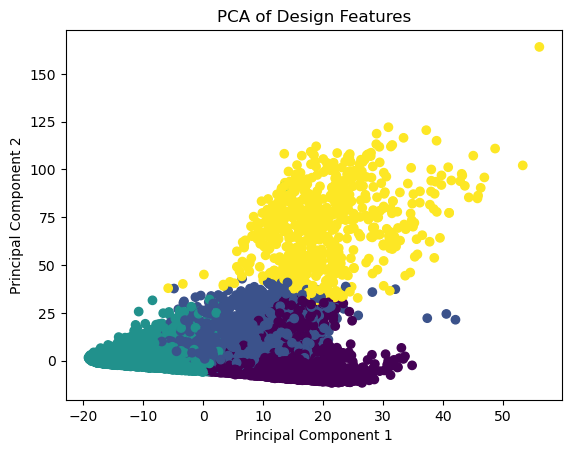

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features_normalized)

# Plot the results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.title('PCA of Design Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [9]:
import numpy as np

# Example: Blend features from two designs
feature_vector1 = combined_features_normalized[np.random.choice(len(combined_features_normalized))]
feature_vector2 = combined_features_normalized[np.random.choice(len(combined_features_normalized))]

new_feature_vector = (feature_vector1 + feature_vector2) / 2

In [10]:
# Example: Add noise to features
noise = np.random.normal(0, 0.1, combined_features_normalized.shape)
augmented_features = combined_features_normalized + noise

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Assume you have some kind of labels from clustering or manual grouping
labels = clusters  # Example: Using clusters as pseudo-labels

# Train Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(combined_features_normalized, labels)

# Train SVM
svm_model = SVC()
svm_model.fit(combined_features_normalized, labels)

SVC()

# Design Generation

In [14]:
import numpy as np
from PIL import Image

# Define the target size and the function to preprocess and extract features from the input image
target_size = (64, 64)

def extract_features_from_image(image_path):
    """Extract combined features from an input image."""
    # Open the image, convert to RGB, resize, and normalize
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0  # Normalize
    
    # Extract individual features using the previously defined functions
    color_features = extract_color_histogram(image_array)
    texture_features = extract_texture_features(image_array)
    hog_features = extract_hog_features(image_array)
    pattern_features = extract_pattern_features(image_array)
    
    # Combine all features into a single feature vector
    combined_features = np.hstack([
        color_features,
        texture_features,
        hog_features,
        pattern_features
    ])
    
    return combined_features, color_features, texture_features, hog_features, pattern_features

def print_features_with_labels(label, features, color, texture, hog, pattern):
    """Prints the features with corresponding labels."""
    print(f"\n{label} Features:")
    
    # Display Color Histogram Features
    print("\nColor Histogram Features:")
    print(color)
    
    # Display Texture Features (LBP)
    print("\nTexture Features (LBP):")
    print(texture)
    
    # Display HOG Features
    print("\nHOG Features:")
    print(hog)
    
    # Display Pattern (Edge) Features
    print("\nPattern Features (Edges):")
    print(pattern)

def generate_new_design(input_image_path):
    """Generate a new design from the input image using the trained models."""
    # Extract features from the input image
    input_features, color_features, texture_features, hog_features, pattern_features = extract_features_from_image(input_image_path)
    
    # Normalize the input features using the same scaler used during training
    input_features_normalized = scaler.transform([input_features])
    
    # Predict the cluster (or class) using Decision Tree and SVM models
    dt_prediction = dt_model.predict(input_features_normalized)
    svm_prediction = svm_model.predict(input_features_normalized)
    
    # Generate new design by blending features (e.g., averaging with another random feature set)
    random_existing_feature = combined_features_normalized[np.random.choice(len(combined_features_normalized))]
    new_design_features = (input_features_normalized + random_existing_feature) / 2
    
    # (Optional) Add a small amount of noise to augment the generated design
    noise = np.random.normal(0, 0.05, new_design_features.shape)
    augmented_design_features = new_design_features + noise
    
    # Extract individual feature components of the generated design
    color_new = augmented_design_features[:, :len(color_features)].flatten()
    texture_new = augmented_design_features[:, len(color_features):len(color_features) + len(texture_features)].flatten()
    hog_new = augmented_design_features[:, len(color_features) + len(texture_features):len(color_features) + len(texture_features) + len(hog_features)].flatten()
    pattern_new = augmented_design_features[:, -len(pattern_features):].flatten()
    
    # Print features with labels for the original input
    print_features_with_labels("Original Input", input_features_normalized.flatten(), color_features, texture_features, hog_features, pattern_features)
    
    # Print features with labels for the generated design
    print_features_with_labels("Generated Design", augmented_design_features.flatten(), color_new, texture_new, hog_new, pattern_new)
    
    # Return the generated feature set for further processing
    return augmented_design_features

# Example usage: Provide the path to an input image and generate a new design
input_image_path = r"D:\Fashion\f\sample\1539.jpg"  # Replace with the path to your input image
new_design = generate_new_design(input_image_path)


Original Input Features:

Color Histogram Features:
[1.1572232e-02 3.7031141e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.5546714e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000